In [1]:
from sklearn import datasets
import numpy as np
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

ZADANIE 1

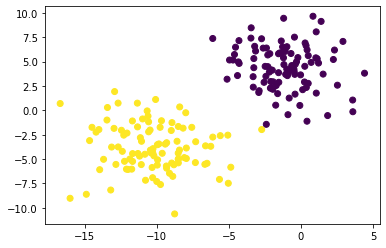

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=200, random_state=1, n_features=2, centers = 2, cluster_std = 2.4)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:
#standaryzacja

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [4]:
# C = 1
svm_c1 = SVC(kernel='linear', C=1., random_state=0)
svm_c1.fit(X_train_std, y_train);

# C = 0.01
svm_c01 = SVC(kernel='linear', C=0.01, random_state=0)
svm_c01.fit(X_train_std, y_train);

# C = 10
svm_c10 = SVC(kernel='linear', C=10, random_state=0)
svm_c10.fit(X_train_std, y_train);

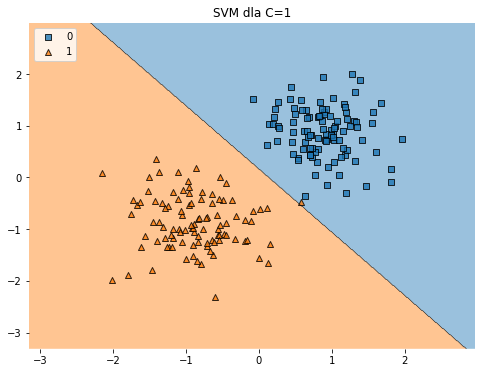

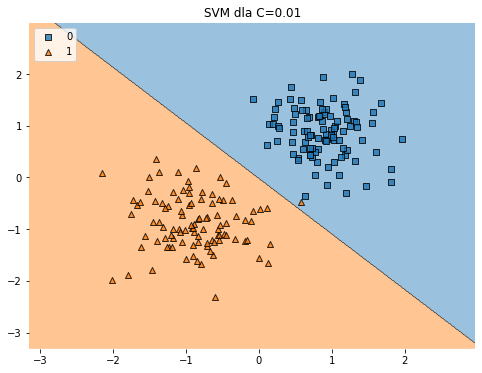

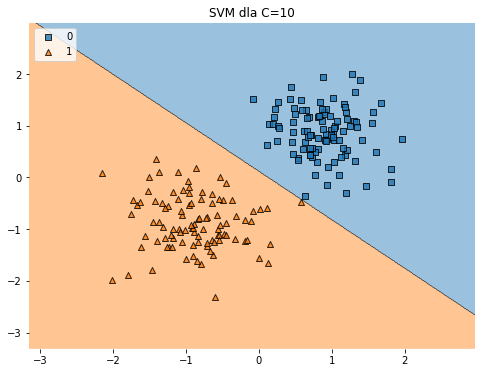

In [5]:
plt.figure(figsize=(8, 6))

X_all = np.vstack( (X_train_std, X_test_std) )
y_all = np.hstack( (y_train, y_test) )

# C = 1
plot_decision_regions(X=X_all, y=y_all, clf=svm_c1)
plt.legend(loc='upper left')
plt.title('SVM dla C=1')
plt.show()

# C = 0.01
plt.figure(figsize=(8, 6))
plot_decision_regions(X=X_all, y=y_all, clf=svm_c01)
plt.legend(loc='upper left')
plt.title('SVM dla C=0.01')
plt.show()

# C = 10
plt.figure(figsize=(8, 6))
plot_decision_regions(X=X_all, y=y_all, clf=svm_c10)
plt.legend(loc='upper left')
plt.title('SVM dla C=10')
plt.show()

ZADANIE 2

In [6]:
# gamma 0.01
svm_g01 = SVC(kernel='rbf', C=1., gamma=0.1, random_state=0)
svm_g01.fit(X_train_std, y_train)

# gamma 10
svm_g10 = SVC(kernel='rbf', C=1., gamma=10, random_state=0)
svm_g10.fit(X_train_std, y_train)

# gamma 50
svm_g50 = SVC(kernel='rbf', C=1., gamma=50, random_state=0)
svm_g50.fit(X_train_std, y_train)

SVC(gamma=50, random_state=0)

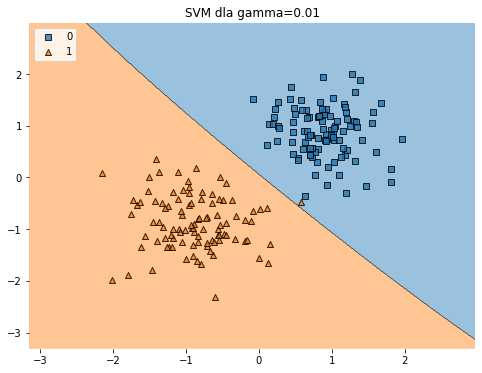

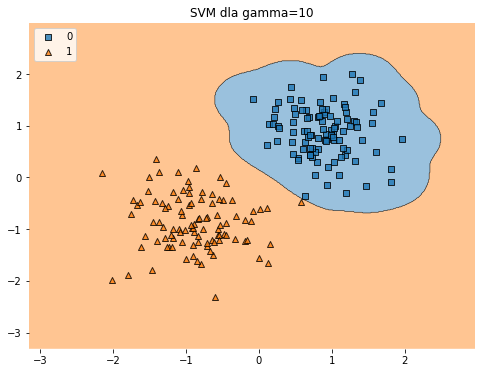

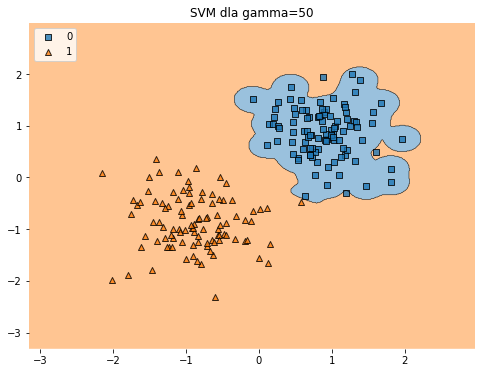

In [7]:
plt.figure(figsize=(8, 6))
plot_decision_regions( X=X_all , y=y_all , clf=svm_g01)
plt.legend(loc='upper left')
plt.title('SVM dla gamma=0.01')
plt.show()

plt.figure(figsize=(8, 6))
plot_decision_regions( X=X_all , y=y_all , clf=svm_g10)
plt.legend(loc='upper left')
plt.title('SVM dla gamma=10')
plt.show()

plt.figure(figsize=(8, 6))
plot_decision_regions( X=X_all , y=y_all , clf=svm_g50)
plt.legend(loc='upper left')
plt.title('SVM dla gamma=50')
plt.show()

ZADANIE 3

In [8]:
import torch

In [9]:
from utils import visualize_optimizer

In [10]:
from checker import test_optimizer

In [11]:
from typing import List

class Optimizer:
    """Base class for each optimizer"""
    
    def __init__(self, initial_params):
        # store model weights
        self.params = initial_params
    
    def step(self):
        """Updates the weights stored in self.params"""
        raise NotImplementedError()
         
    def zero_grad(self):
        """Torch accumulates gradients, so we need to clear them after every update"""
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

In [12]:
# metoda spadku gradientu

class GradientDescent(Optimizer):
    
    def __init__(self, initial_params: List[torch.tensor], learning_rate):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
    
    @torch.no_grad()
    def step(self):
        for param in self.params:
            # Please note that it's important to change the parameters in-place (-=) so the original tensors are modified
            param -= self.learning_rate * param.grad

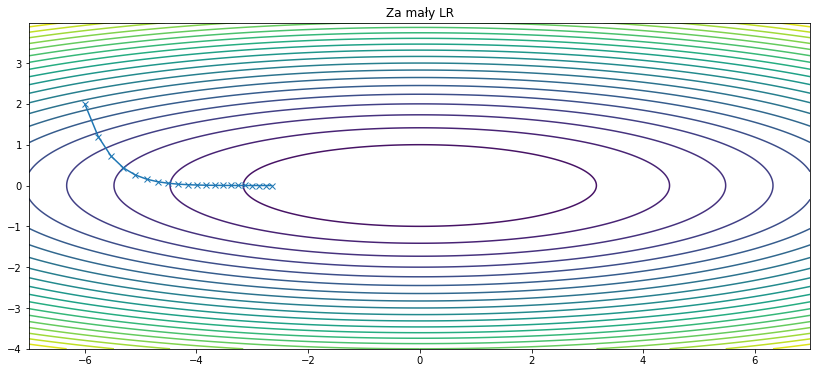

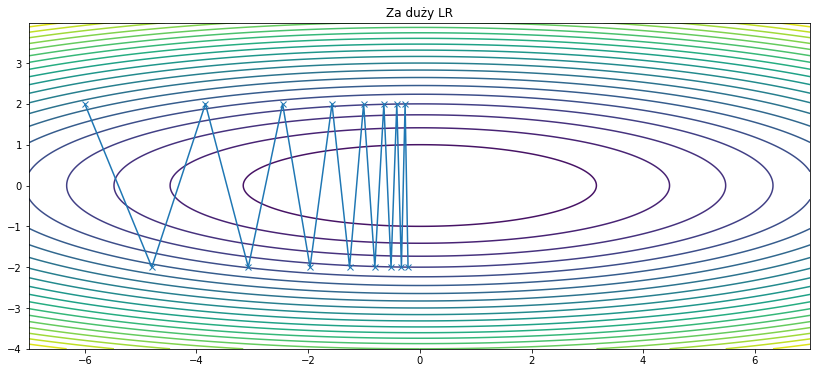

In [13]:
visualize_optimizer(GradientDescent, n_steps=20, learning_rate=0.1, title='Za mały LR')
visualize_optimizer(GradientDescent, n_steps=15, learning_rate=0.5, title='Za duży LR')

In [14]:
class Momentum(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma):
        super().__init__(initial_params)
        
        self.learning_rate = learning_rate
        self.gamma = gamma
        
        self.deltas = []
        
        for param in self.params:
            self.deltas.append(torch.zeros_like(param))
              
    @torch.no_grad()
    def step(self):  
        
        for param, delta in zip(self.params, self.deltas):
            
            delta *= self.gamma
            delta += self.learning_rate * param.grad
            param -= delta

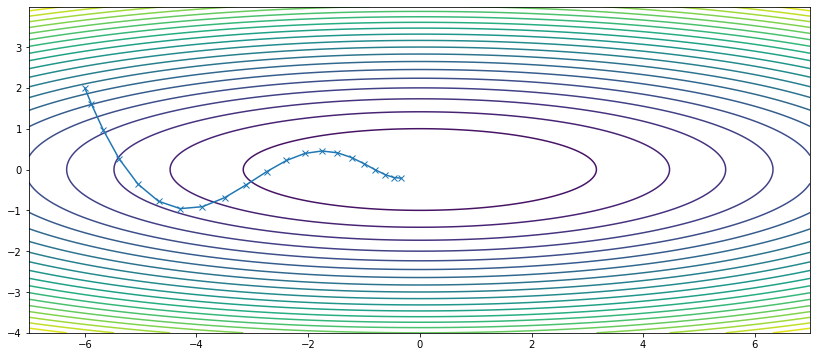

In [15]:
visualize_optimizer(Momentum, n_steps=20, learning_rate=0.05, gamma=0.8)

ZADANIE 4

In [35]:
class Adagrad(Optimizer):
    
    def __init__(self, initial_params, learning_rate, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        
        self.G = 0
    
    @torch.no_grad()
    def step(self):
        
        for param, i in zip(self.params, range(len(self.params))):
            
            self.G += torch.pow(param.grad[i], 2)
                           
            param -= (self.learning_rate/torch.sqrt(self.G + self.epsilon)) * param.grad

In [36]:
test_optimizer(Adagrad)

AssertionError: 

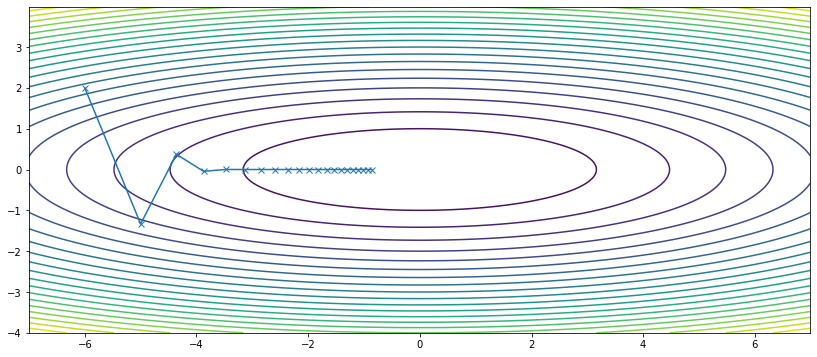

In [37]:
visualize_optimizer(Adagrad, n_steps=20, learning_rate=1.0, epsilon=1e-8)

ZADANIE 5

In [22]:
class RMSProp(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.H = []
        
        for param in self.params:
            self.H.append(torch.zeros_like(param))
        
    @torch.no_grad()
    def step(self):
        for param, H in zip(self.params, self.H):
            
            H *= self.gamma
            H += (1-self.gamma)*torch.pow(param.grad,2)
        
            param -= self.learning_rate/(torch.sqrt(H + self.epsilon))*param.grad

In [23]:
test_optimizer(RMSProp)

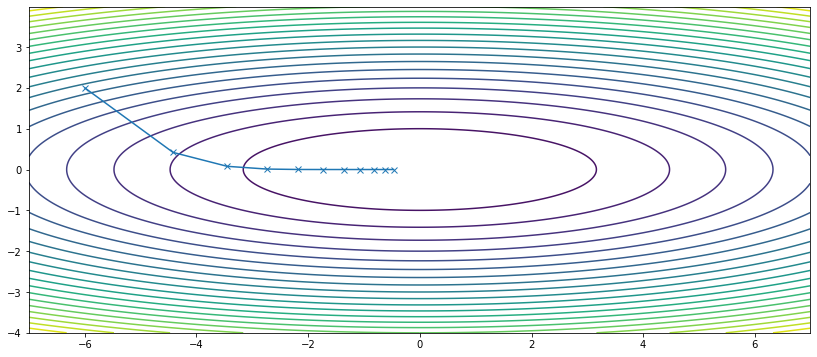

In [24]:
visualize_optimizer(RMSProp, n_steps=10, learning_rate=0.5, gamma=0.9, epsilon=1e-8)

ZADANIE 6

In [25]:
class Adadelta(Optimizer):
    def __init__(self, initial_params, gamma, epsilon):
        super().__init__(initial_params)
        self.gamma = gamma
        self.epsilon = epsilon

        self.H = []
        
        for param in self.params:
            self.H.append(torch.zeros_like(param))
        
        self.D = []
        
        for param in self.params:
            self.D.append(torch.zeros_like(param))
            
        
        
    @torch.no_grad()
    def step(self):
        for param, H, D in zip(self.params, self.H, self.D):
            
            H *= self.gamma
            H += (1-self.gamma)*torch.pow(param.grad, 2)
            delta = (torch.sqrt(D + self.epsilon)/torch.sqrt(H + self.epsilon))*param.grad
            param -= delta
            D *= self.gamma
            D += (1-self.gamma)*torch.pow(delta, 2)
            

In [26]:
test_optimizer(Adadelta)

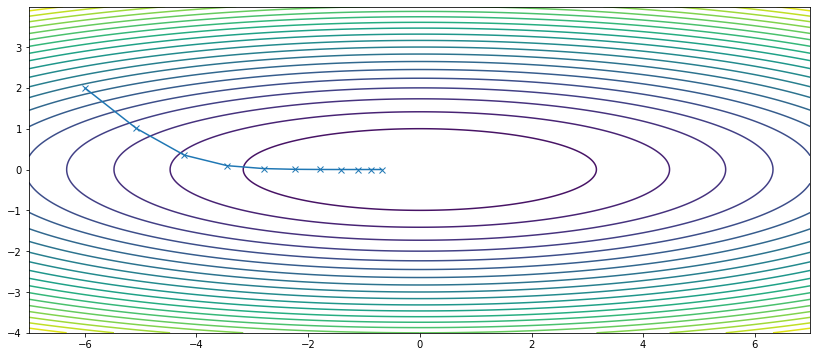

In [27]:
visualize_optimizer(Adadelta, n_steps=10, gamma=0.9, epsilon=1e-1) #obrazek inny 

ZADANIE 7

In [28]:
class Adam(Optimizer):
   
    def __init__(self, initial_params, learning_rate, beta1, beta2, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        self.m = []
        
        for param in self.params:
            self.m.append(torch.zeros_like(param))
            
        self.v = []
        
        for param in self.params:
            self.v.append(torch.zeros_like(param))
            
        self.i = 0
        
    @torch.no_grad()
    def step(self,):
        for param, m, v in zip(self.params, self.m, self.v):
            
            m *= self.beta1
            m += (1-self.beta1)*param.grad
            v *= self.beta2
            v += (1-self.beta2)*torch.pow(param.grad, 2)
            
            
            
            m_new = m/(1 - self.beta1**(self.i + 1))
            v_new = v/(1 - self.beta2**(self.i + 1))
                
            param -= self.learning_rate*m_new/(torch.sqrt(v_new) + self.epsilon)
            
        self.i += 1
        

In [29]:
test_optimizer(Adam)

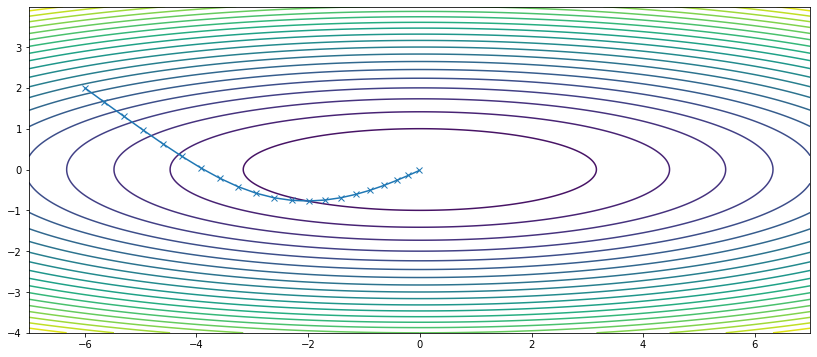

In [30]:
visualize_optimizer(Adam, n_steps=20, learning_rate=0.35, beta1=0.9, beta2=0.999, epsilon=1e-8)


In [31]:
#Operacje na tensorach
x = torch.tensor([4, 9])
print(torch.sqrt(x)) #pierwiastki
print()
print(torch.pow(x, 2)) #potęgi

tensor([2., 3.])

tensor([16, 81])
